**3장 – 분류**

_이 노트북은 3장의 모든 샘플 코드와 연습 문제 정답을 담고 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 3.0 설정

파이썬 3.7 또는 그 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

Scikit-Learn ≥1.0.1이 필요합니다:

In [1]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

이전 장과 마찬가지로 그래프를 보기 좋게 그리기 위해 기본 폰트 크기를 설정합니다:

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

`images/` 폴더가 없다면 이 폴더를 만들고 고해상도 이미지 저장을 위해 노트북에서 사용할 `save_fig()` 함수를 정의합니다:

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 3.1 MNIST

In [4]:

# 사이킷런 1.2에서 추가된 parser 매개변수 기본값이 1.4 버전에서 'liac-arff'에서 'auto'로 바뀝니다.
# 'auto'일 경우 희소한 ARFF 포맷일 때는 'liac-arff', 그렇지 않을 때는 'pandas'가 됩니다.
# 이에 대한 경고를 피하려면 parser='auto'로 지정하세요.
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [5]:
# 추가 코드 - 조금 내용이 깁니다
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [6]:
mnist.keys()  # 추가 코드 - 이 노트북에서는 data와 target만 사용합니다


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
X.shape

(70000, 784)

In [9]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [10]:
y.shape

(70000,)

In [11]:
28 * 28

784

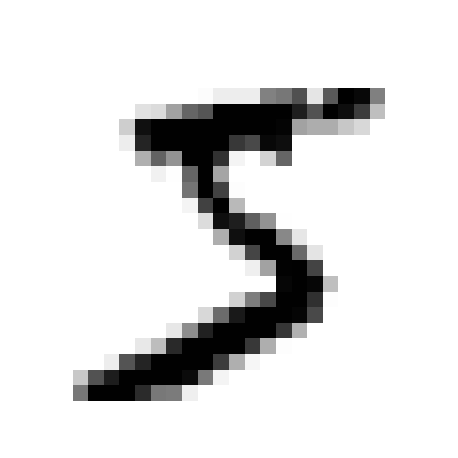

In [12]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # 추가 코드
plt.show()

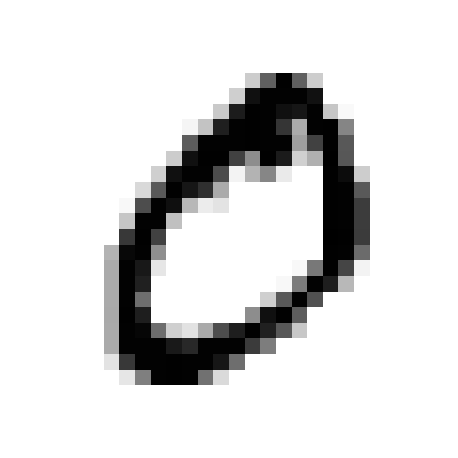

In [13]:
some_digit = X[1]
plot_digit(some_digit)
save_fig("some_digit_plot_0")  # 추가 코드
plt.show()

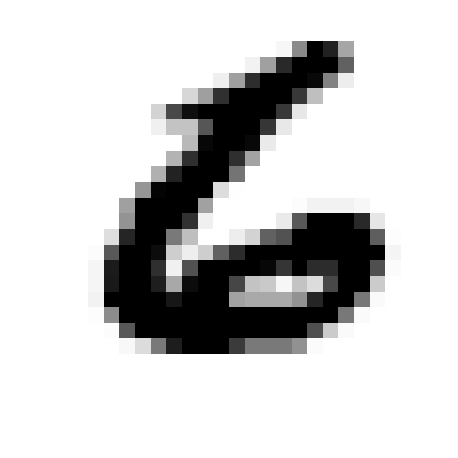

In [15]:
some_digit = X[-1]
plot_digit(some_digit)
save_fig("some_digit_plot_6")  # 추가 코드
plt.show()

In [17]:
print(y[0])
print(y[1])
print(y[-1])

5
0
6


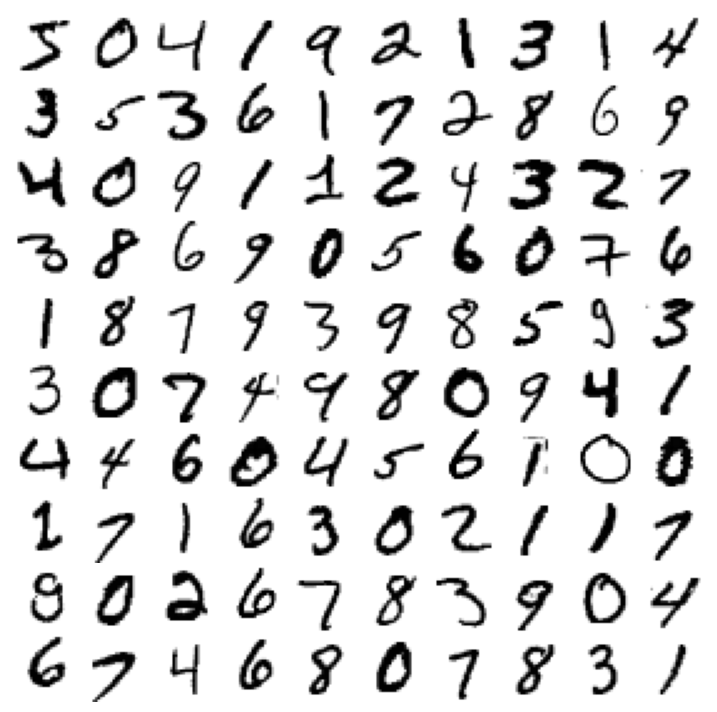

In [16]:
# 추가 코드 – 그림 3–2를 생성하고 저장합니다
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [18]:
X_train, X_test, y_train, y_test = \
    X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

In [19]:
# 5는 True고, 다른 숫자는 모두 False
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [20]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [25]:
index = -1
some_digit = X[index]
print(y[index])
sgd_clf.predict([some_digit])

6


array([False])

# 3.3 성능 측정

## 3.3.1 교차 검증을 사용한 정확도 측정

In [26]:
# cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # 데이터셋이 미리 섞여 있지 않다면
                                       # shuffle=True를 추가하세요.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

In [ ]:
# DummyClassifier


In [ ]:
# cross_val_score(...) DummyClassifier


## 3.3.2 오차 행렬

In [29]:
# cross_val_predict
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [32]:
y_train

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

In [33]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [31]:
# confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [34]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우

cm = confusion_matrix(y_train_5, y_train_perfect_predictions)
cm

array([[54579,     0],
       [    0,  5421]])

## 3.3.3 정밀도와 재현율

In [35]:
# precision_score, recall_score
from sklearn.metrics import precision_score, recall_score
# precision_score
precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

np.float64(0.8370879772350012)

In [36]:
# 추가 코드 – TP / (FP + TP) 식으로 정밀도를 계산합니다

cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(1.0)

In [37]:
# recall_score
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

np.float64(0.6511713705958311)

In [38]:
# 추가 코드 – TP / (FN + TP) 식으로 정밀도를 계산합니다
cm[1, 1] / (cm[1, 0] + cm[1, 1])

np.float64(1.0)

In [39]:
# f1_score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

In [40]:
# 추가 코드 – f1 점수를 계산합니다
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

np.float64(1.0)

## 3.3.4 정밀도/재현율 트레이드오프

In [42]:
some_digit = X[0]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [43]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [44]:
y_some_digit_pred

array([ True])

In [45]:
# 추가 코드 – y_scores > 0이면 predict()를 호출하는 것과 같은 결과를 냅니다
y_scores > 0

array([ True])

In [46]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [47]:
# y_scores = cross_val_predict(...)

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [48]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [51]:
X[0].shape

(784,)

In [52]:
# precision_recall_curve

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [53]:
thresholds, precisions

(array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
          38871.26391927,   42216.05562787,   49441.43765905]),
 array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
        1.        ]))

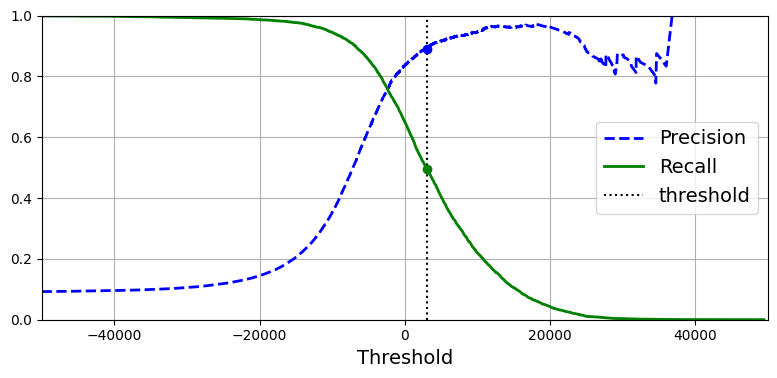

In [54]:
plt.figure(figsize=(8, 4))  # 추가 코드
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# 추가 코드 – 그림 3–5를 그리고 저장합니다
idx = (thresholds >= threshold).argmax()  # 첫 번째 index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

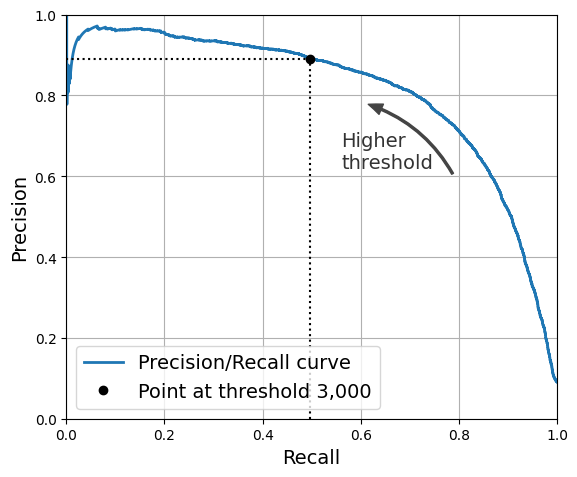

In [55]:
import matplotlib.patches as patches  # 추가 코드 – 구부러진 화살표를 그리기 위해서

plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [56]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [57]:
y_train_pred_90 = (y_scores>=threshold_for_90_precision)

In [58]:
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [59]:
recall_score(y_train_5, y_train_pred_90)

np.float64(0.4799852425751706)

## 3.3.5 ROC 곡선

In [60]:
# roc_curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

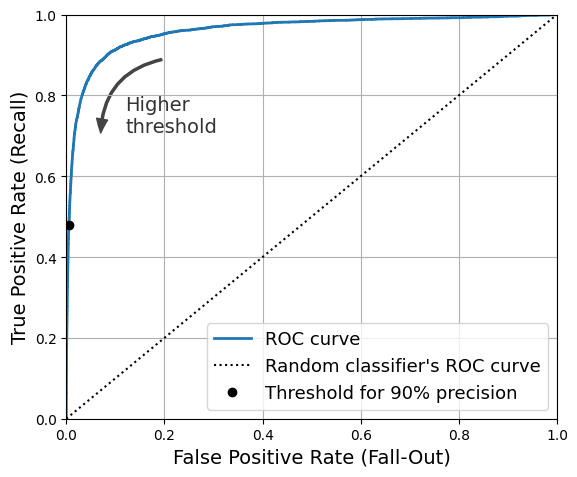

In [61]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # 추가 코드
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# 추가 코드 – 그림 3–7을 그리고 저장합니다
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [62]:
# roc_auc_score
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다.

In [63]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)

In [64]:
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3,
    method = "predict_proba"
)

In [65]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

이는 _추정 확률(estimated probabilities)_입니다. 모델이 50%에서 60% 사이의 확률로 양성으로 분류한 이미지 중 실제로는 약 94%의 양성 이미지가 있습니다:

In [66]:
# 책에는 없음
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [67]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve()

In [68]:
plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# 추가 코드 – 그림 3–8을 그리고 저장합니다
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

NameError: name 'recalls_forest' is not defined

<Figure size 600x500 with 0 Axes>

`cross_val_predict(forest_clf, X_train, y_train_5, cv=3)`을 호출하여 `y_train_pred_forest`을 계산할 수 있습니다.
하지만 이미 추정 확률을 가지고 있기 때문에 기본 50% 임곗값과 비교하면 훨씬 빠르게 예측을 얻을 수 있습니다:

In [ ]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # 양성 확률 ≥ 50%
# f1_score(...)

In [ ]:
# roc_auc_score(...)

In [ ]:
# precision_score(...)

In [ ]:
# recall_score(...)

# 3.4 다중 분류

SVM은 대용량 데이터셋에 잘 맞지 않기 때문에 처음 2,000개의 샘플만 사용해 훈련합니다. 그렇지 않으면 아주 오랜 시간이 걸립니다:

In [71]:
# SVC
from sklearn.svm import SVC
# y_train_5가 아니고 y_train을 사용합니다.
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [72]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [73]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [74]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [75]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [76]:
svm_clf.classes_[class_id]

'5'

`decision_function()`이 45개 점수를 반환하게 하려면 `decision_function_shape` 매개변수를 `"ovo"`로 지정합니다. 기본값은 `"ovr"`이지만 혼동하지 마세요. `SVC`는 항상 OvO로 훈련합니다. 이 매개변수는 45개 점수를 반환할지 여부에만 영향을 미칩니다:

In [77]:
# 추가 코드 – 45개 OvO 점수를 얻는 방법
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [78]:
# OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [79]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [80]:
len(ovr_clf.estimators_)

10

In [81]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [82]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다.

In [83]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
# StandardScaler


# 3.5 에러 분석

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다.

In [85]:
# ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))

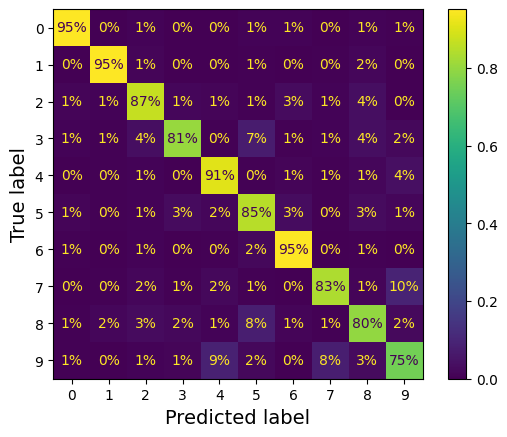

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(
    sgd_clf, X_train, y_train,cv=3
)
plt.rc('font', size=10)  # 추가 코드
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
# save_fig()
plt.show()

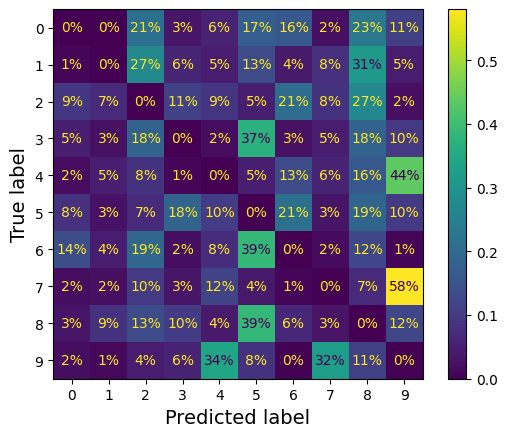

In [89]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # 추가 코드
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
# save_fig()
plt.show()

책에 있는 그래프를 그립니다:

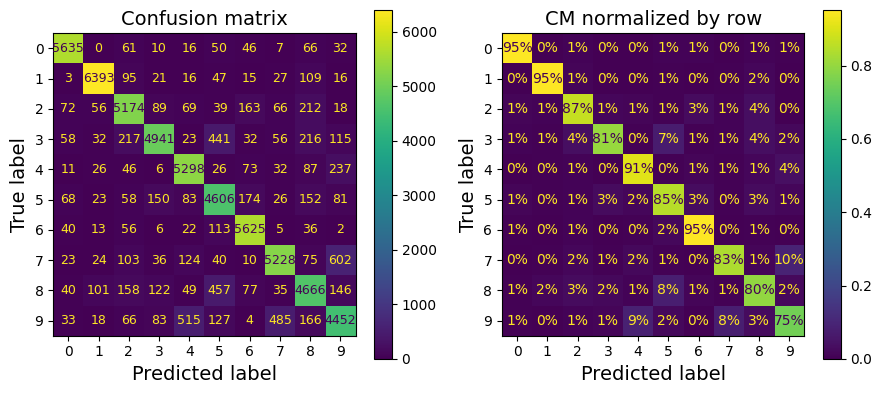

In [90]:
# 추가 코드 – 그림 3–9을 생성하고 저장합니다
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

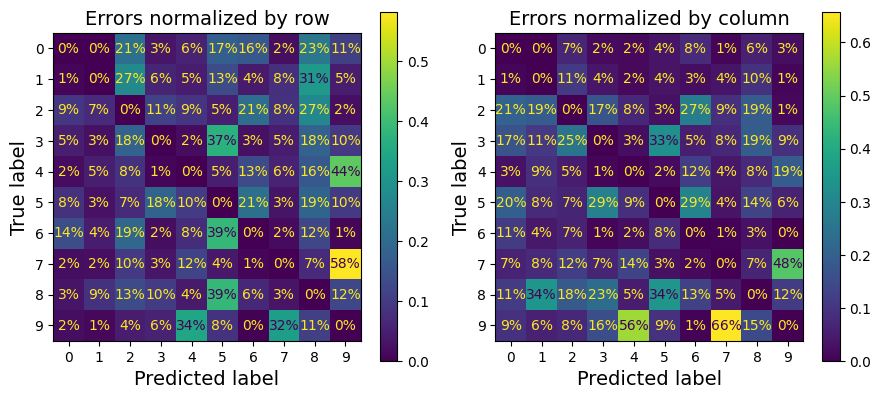

In [91]:
# 추가 코드 – 그림 3–10을 생성하고 저장합니다
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # 폰트 크기를 다시 키웁니다

In [79]:
cl_a, cl_b = '3', '5'
# ...

In [ ]:
# 추가 코드 – 그림 3–11을 생성하고 저장합니다
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

노트: 이와 같은 그래프를 그리는 방법이 여러 가지가 있지만 축 레이블을 올바르게 쓰기가 조금 어렵습니다:
* [nested GridSpecs](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html)
* 각 블록의 모든 숫자를 하나의 이미지로 합치기 (그다음 2x2 서브플롯 사용하기). 예를 들면:
    ```python
    X_aa[:25].reshape(5, 5, 28, 28).transpose(0, 2, 1, 3).reshape(5 * 28, 5 * 28)
    ```
* [subfigures](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html) (맷플롯립 3.4 이상)

# 3.6 다중 레이블 분류

In [ ]:
# KNeighborsClassifier


In [ ]:
knn_clf.predict([some_digit])

**경고:** 다음 셀은 실행하는데 몇 분이 걸릴 수 있습니다:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
# 추가 코드 – average="weighted"로 지정했을 때 성능 향상은 무시할 수 있는 수준입니다.
#           이 클래스는 이미 꽤 균형 잡혀 있기 때문입니다.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

In [ ]:
# ClassifierChain


In [ ]:
chain_clf.predict([some_digit])

# 3.7 다중 출력 분류

In [87]:
np.random.seed(42)  # 동일하게 재현되게 하려고 지정합니다
# noise =

In [ ]:
# 추가 코드 – 그림 3–12을 생성하고 저장합니다
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
# knn_clf = KNeighborsClassifier()

# save_fig("cleaned_digit_example_plot")  # 추가 코드 – 그림 3–13을 저장합니다
plt.show()